# Process
1. 랜덤으로 700명 추출
2. Base Loss 측정
3. 각 피처마다 0 -> 1, 1 -> 0으로 바꾸어서 모델 train, predict 후 loss 측정
4. 비교 DF 생성

In [1]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings(action='ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


# get_model, BinaryCrossEntropy

In [2]:
def get_model():
    seed_num = 48
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(X.shape[1],X.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate = 0.001)
    lstm.compile(optimizer=optimizer, loss = "binary_crossentropy", metrics=['acc'])
    return lstm

In [3]:
def BinaryCrossEntropy(y_true, y_pred):
    m = y_true.shape[1]
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    # Calculating loss
    loss = -1/m * (np.dot(y_true.T, np.log(y_pred)) + np.dot((1 - y_true).T, np.log(1 - y_pred)))

    return loss

# Reversed Feature - 700
- https://stackoverflow.com/questions/39164786/invert-0-and-1-in-a-binary-array

In [77]:
import random    
seed_num = 48
random.seed(seed_num)

X = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)

X_700 = X[idx[:700]]
y_700 = y[idx[:700]]
print(X_700.shape)

i = round(X_700.shape[0]*0.8)
X_train, y_train = X_700[:i,:,:], y_700[:i]
X_test, y_test = X_700[i:,:,:], y_700[i:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(700, 10, 4069)


((560, 10, 4069), (560,), (140, 10, 4069), (140,))

In [78]:
X_700.shape, y_700.shape

((700, 10, 4069), (700,))

In [79]:
model = get_model()
early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
4/4 [==============================] - 3s 155ms/step - loss: 0.6796 - acc: 0.6048 - val_loss: 0.6735 - val_acc: 0.6000
Epoch 2/500
4/4 [==============================] - 0s 58ms/step - loss: 0.6637 - acc: 0.6071 - val_loss: 0.6731 - val_acc: 0.6000
Epoch 3/500
4/4 [==============================] - 0s 58ms/step - loss: 0.6779 - acc: 0.6048 - val_loss: 0.6731 - val_acc: 0.6000
Epoch 4/500
4/4 [==============================] - 0s 55ms/step - loss: 0.6732 - acc: 0.6048 - val_loss: 0.6732 - val_acc: 0.6000
Epoch 5/500
4/4 [==============================] - 0s 56ms/step - loss: 0.6724 - acc: 0.6024 - val_loss: 0.6732 - val_acc: 0.6000
Epoch 6/500
4/4 [==============================] - 0s 56ms/step - loss: 0.6738 - acc: 0.6095 - val_loss: 0.6733 - val_acc: 0.6000
Epoch 7/500
4/4 [==============================] - 0s 55ms/step - loss: 0.6714 - acc: 0.6071 - val_loss: 0.6731 - val_acc: 0.6000
Epoch 8/500
4/4 [==============================] - 0s 55ms/step - loss: 0.6732 - acc: 0.6

In [80]:
pred = model.predict(X_test)
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
base_bce_700 = BinaryCrossEntropy(pred, y_test)[0]

## COLS, reverse function

In [7]:
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/guri/data/data2d_forposter.csv').columns)

In [8]:
#reverse 함수 생성
a = [1,0,0,1,0,1]
def reverse(li):
    return np.logical_not(li).astype(np.float64)

reverse(a)

array([0., 1., 1., 0., 1., 0.])

## 700 result

In [83]:
results = []
results.append({'feature':'BASELINE', 'bce':base_bce_700})
for i in tqdm(range(len(COLS))):
    save_col = X_test[:,:,i].copy()
    for p in range(X_test.shape[0]):
        X_test[p,:,i] = reverse(X_test[p,:,i])
        
    pred = model.predict(X_test)
    bce = BinaryCrossEntropy(pred, y_test)[0]
    results.append({'feature':COLS[i], 'bce':bce})
    X_test[:,:,i] = save_col

  0%|          | 0/4069 [00:00<?, ?it/s]

In [84]:
df = pd.DataFrame(results)
df = df.sort_values('bce', ascending=False)
df

,feature,bce
3834,63323026201,945.888091
207,51277,942.538465
2052,338500241,938.744749
1,0,936.068178
84,50956,935.338353
...,...,...
13,50821,913.981922
12,50820,913.958896
3900,63739002401,913.953672
2051,338355248,913.278603


# ALL (7727)

In [61]:
import random    
seed_num = 48
random.seed(seed_num)

X = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[:i,:,:], y[:i]
X_test, y_test = X[i:,:,:], y[i:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4069), (6182,), (1545, 10, 4069), (1545,))

In [62]:
model = get_model()
early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
37/37 [==============================] - 5s 64ms/step - loss: 0.6255 - acc: 0.6872 - val_loss: 0.7495 - val_acc: 0.4955
Epoch 2/500
37/37 [==============================] - 2s 53ms/step - loss: 0.6240 - acc: 0.6887 - val_loss: 0.7583 - val_acc: 0.4955
Epoch 3/500
37/37 [==============================] - 2s 53ms/step - loss: 0.6265 - acc: 0.6885 - val_loss: 0.7581 - val_acc: 0.4955
Epoch 4/500
37/37 [==============================] - 2s 53ms/step - loss: 0.5813 - acc: 0.6943 - val_loss: 0.6175 - val_acc: 0.6953
Epoch 5/500
37/37 [==============================] - 2s 54ms/step - loss: 0.4594 - acc: 0.7871 - val_loss: 0.5644 - val_acc: 0.7277
Epoch 6/500
37/37 [==============================] - 2s 54ms/step - loss: 0.3944 - acc: 0.8281 - val_loss: 0.5836 - val_acc: 0.7212
Epoch 7/500
37/37 [==============================] - 2s 53ms/step - loss: 0.3458 - acc: 0.8598 - val_loss: 0.6110 - val_acc: 0.7342
Epoch 8/500
37/37 [==============================] - 2s 53ms/step - loss: 0.

In [63]:
pred = model.predict(X_test)
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
base_bce = BinaryCrossEntropy(pred, y_test)[0]

In [64]:
results = []
results.append({'feature':'BASELINE', 'bce':base_bce})

for i in tqdm(range(len(COLS))):
    #원본 저장해놓고 for문 하나 끝날 때 다시 복원해준다. - save_col
    save_col = X_test[:,:,i].copy()
    for p in range(X_test.shape[0]):
        X_test[p,:,i] = reverse(X_test[p,:,i])
        
    pred = model.predict(X_test)
    bce = BinaryCrossEntropy(pred, y_test)[0]
    results.append({'feature':COLS[i], 'bce':bce})
    X_test[:,:,i] = save_col

  0%|          | 0/4069 [00:00<?, ?it/s]

In [70]:
df1 = pd.DataFrame(results)
df1 = df1.sort_values('bce', ascending=False)
df1

,feature,bce
2197,409606211,10634.860764
3285,51479005520,9598.850359
1082,67434504,9274.589349
1277,74606211,9222.603923
3588,59011010325,9214.718024
...,...,...
2155,409198530,7929.591817
2191,409490234,7914.460668
306,224275,7910.113561
3458,55390000401,7906.018468


In [71]:
df1.to_csv('./reverse_FI.csv', index=False)
a = pd.read_csv('./reverse_FI.csv')

In [72]:
a[-10:]

,feature,bce
4060,338004904,7940.537330
4061,74131702,7940.033262
4062,409131230,7939.818158
4063,409433201,7937.969892
4064,574705050,7935.889340
4065,409198530,7929.591817
4066,409490234,7914.460668
4067,224275,7910.113561
4068,55390000401,7906.018468
4069,6473900,7830.683974


# ALL (7727) - D-1~5
- `X_test[p,:,i]` 부분을 `X_test[p,-5:,i]`로 수정

In [85]:
import random    
seed_num = 48
random.seed(seed_num)

X = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[:i,:,:], y[:i]
X_test, y_test = X[i:,:,:], y[i:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4069), (6182,), (1545, 10, 4069), (1545,))

In [86]:
#위에서 ALL(7727) 실행했다면, 그 모델 그대로 사용! (즉, 이 cell 생략 가능 어차피 같은 데이터, 같은 모델이기 때문에)
model = get_model()
early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
37/37 [==============================] - 5s 63ms/step - loss: 0.6255 - acc: 0.6872 - val_loss: 0.7495 - val_acc: 0.4955
Epoch 2/500
37/37 [==============================] - 2s 53ms/step - loss: 0.6240 - acc: 0.6887 - val_loss: 0.7583 - val_acc: 0.4955
Epoch 3/500
37/37 [==============================] - 2s 53ms/step - loss: 0.6265 - acc: 0.6885 - val_loss: 0.7581 - val_acc: 0.4955
Epoch 4/500
37/37 [==============================] - 2s 53ms/step - loss: 0.5813 - acc: 0.6943 - val_loss: 0.6175 - val_acc: 0.6953
Epoch 5/500
37/37 [==============================] - 2s 53ms/step - loss: 0.4594 - acc: 0.7871 - val_loss: 0.5644 - val_acc: 0.7277
Epoch 6/500
37/37 [==============================] - 2s 53ms/step - loss: 0.3944 - acc: 0.8281 - val_loss: 0.5836 - val_acc: 0.7212
Epoch 7/500
37/37 [==============================] - 2s 53ms/step - loss: 0.3458 - acc: 0.8598 - val_loss: 0.6110 - val_acc: 0.7342
Epoch 8/500
37/37 [==============================] - 2s 54ms/step - loss: 0.

In [87]:
pred = model.predict(X_test)
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
base_bce = BinaryCrossEntropy(pred, y_test)[0]

In [96]:
results = []
results.append({'feature':'BASELINE', 'bce':base_bce})

for i in tqdm(range(len(COLS))):
    save_col = X_test[:,:,i].copy()
    for p in range(X_test.shape[0]):
        X_test[p,-5:,i] = reverse(X_test[p,-5:,i])
    pred = model.predict(X_test)
    bce = BinaryCrossEntropy(pred, y_test)[0]
    results.append({'feature':COLS[i], 'bce':bce})
    X_test[:,:,i] = save_col
    

  0%|          | 0/4069 [00:00<?, ?it/s]

In [ ]:
df2 = pd.DataFrame(results)
df2 = df2.sort_values('bce', ascending=False)
df2

In [ ]:
df2.to_csv('./reverse_FI_d1d5.csv', index=False)

In [4]:
a = pd.read_csv('./reverse_FI_d1d5.csv')
a

,feature,bce
0,409606211,10338.055660
1,51479005520,9306.662853
2,74606211,9226.959121
3,67434504,9206.570207
4,59011010325,9053.431215
...,...,...
4065,641607325,7964.610127
4066,555077002,7963.532106
4067,55390000401,7962.112998
4068,10019003867,7949.474121


# ALL (7727) - D-6~10
- `X_test[p,:,i]` 부분을 `X_test[p,:5,i]`로 수정

In [8]:
import random    
seed_num = 48
random.seed(seed_num)

X = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[:i,:,:], y[:i]
X_test, y_test = X[i:,:,:], y[i:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4069), (6182,), (1545, 10, 4069), (1545,))

In [9]:
#위에서 ALL(7727) 실행했다면, 그 모델 그대로 사용! (즉, 이 cell 생략 가능 어차피 같은 데이터, 같은 모델이기 때문에)
model = get_model()
early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
37/37 [==============================] - 5s 68ms/step - loss: 0.6255 - acc: 0.6872 - val_loss: 0.7495 - val_acc: 0.4955
Epoch 2/500
37/37 [==============================] - 2s 54ms/step - loss: 0.6240 - acc: 0.6887 - val_loss: 0.7583 - val_acc: 0.4955
Epoch 3/500
37/37 [==============================] - 2s 54ms/step - loss: 0.6265 - acc: 0.6885 - val_loss: 0.7581 - val_acc: 0.4955
Epoch 4/500
37/37 [==============================] - 2s 54ms/step - loss: 0.5813 - acc: 0.6943 - val_loss: 0.6175 - val_acc: 0.6953
Epoch 5/500
37/37 [==============================] - 2s 53ms/step - loss: 0.4594 - acc: 0.7871 - val_loss: 0.5644 - val_acc: 0.7277
Epoch 6/500
37/37 [==============================] - 2s 54ms/step - loss: 0.3944 - acc: 0.8281 - val_loss: 0.5836 - val_acc: 0.7212
Epoch 7/500
37/37 [==============================] - 2s 54ms/step - loss: 0.3458 - acc: 0.8598 - val_loss: 0.6110 - val_acc: 0.7342
Epoch 8/500
37/37 [==============================] - 2s 54ms/step - loss: 0.

In [10]:
pred = model.predict(X_test)
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
base_bce = BinaryCrossEntropy(pred, y_test)[0]

In [15]:
results = []
results.append({'feature':'BASELINE', 'bce':base_bce})

for i in tqdm(range(len(COLS))):
    save_col = X_test[:,:,i].copy()
    for p in range(X_test.shape[0]):
        X_test[p,:5,i] = reverse(X_test[p,:5,i])
    pred = model.predict(X_test)
    bce = BinaryCrossEntropy(pred, y_test)[0]
    results.append({'feature':COLS[i], 'bce':bce})
    X_test[:,:,i] = save_col

  0%|          | 0/4069 [00:00<?, ?it/s]

In [16]:
df3 = pd.DataFrame(results)
df3 = df3.sort_values('bce', ascending=False)
df3

,feature,bce
2197,409606211,8160.815718
3285,51479005520,8157.391308
2740,10019021302,8127.108366
158,51148,8119.904766
1427,83000730,8116.012745
...,...,...
39,50890,7947.933948
307,224276,7947.564285
3854,63323038810,7943.017285
18,50856,7942.537136


In [17]:
df3.to_csv('./reverse_FI_d6d10.csv', index=False)

In [18]:
a = pd.read_csv('./reverse_FI_d6d10.csv')
a

,feature,bce
0,409606211,8160.815718
1,51479005520,8157.391308
2,10019021302,8127.108366
3,51148,8119.904766
4,83000730,8116.012745
...,...,...
4065,50890,7947.933948
4066,224276,7947.564285
4067,63323038810,7943.017285
4068,50856,7942.537136


# 비교

In [4]:
fi_all = pd.read_csv('./reverse_FI.csv')
fi_d1d5 = pd.read_csv('./reverse_FI_d1d5.csv')
fi_d6d10 = pd.read_csv('./reverse_FI_d6d10.csv')

In [5]:
print(fi_all.feature[:10].to_list())
print(fi_d1d5.feature[:10].to_list())
print(fi_d6d10.feature[:10].to_list())

['409606211', '51479005520', '67434504', '74606211', '59011010325', '54858516', '83000730', '409115170', '50927', '51148']
['409606211', '51479005520', '74606211', '67434504', '59011010325', '54858516', '50927', '409115170', '83000730', '2411260']
['409606211', '51479005520', '10019021302', '51148', '83000730', '59011010325', '121048910', '49669521303', '173024256', '2411260']


In [18]:
base_binary_crossentropy = fi_all[fi_all['feature']=='BASELINE']['bce'].iloc[0]

In [21]:
fi_all[fi_all['feature']=='BASELINE']

,feature,bce
2410,BASELINE,8008.864772


In [52]:
#df : FI 데이터프레임, n : 상위 몇 개를 볼 것인지
#df, n을 받아서 df의 상위 n개 barh그래프 그려주는 함수
def plot_fi(df, n):
    plot_df = df[:n]
    plt.figure(figsize=(10,20))
    plt.barh(np.arange(n-1, -1, -1), plot_df.bce)
    plt.yticks(np.arange(n-1, -1, -1), plot_df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1, n))
    plt.plot([base_binary_crossentropy,base_binary_crossentropy],[-1,n], '--', color='orange',
             label=f'Baseline OOF\nMAE={base_binary_crossentropy:.5f}')
    # plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()

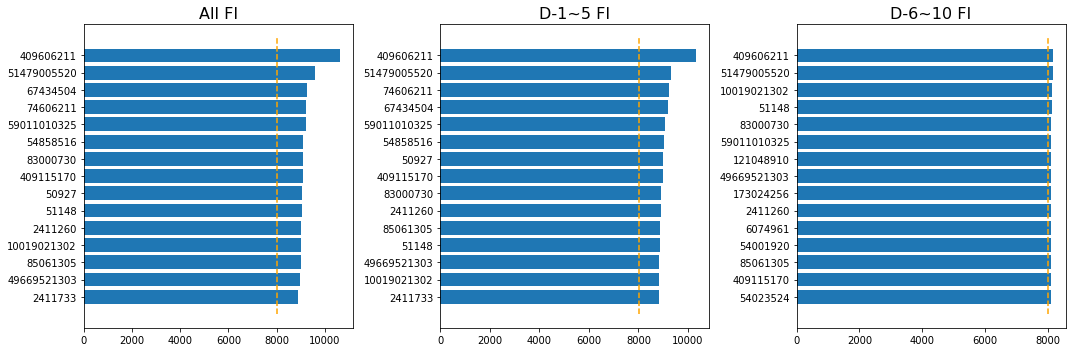

In [82]:
top_n = 15

fig = plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.barh(np.arange(top_n-1, -1, -1), fi_all[:top_n].bce)
_=plt.yticks(np.arange(top_n-1, -1, -1), fi_all[:top_n].feature.values)
plt.plot([base_binary_crossentropy,base_binary_crossentropy],[-1,top_n], '--', color='orange',
             label=f'Baseline OOF\nMAE={base_binary_crossentropy:.5f}')
plt.title('All FI',size=16)

plt.subplot(1,3,2)
plt.barh(np.arange(top_n-1, -1, -1), fi_d1d5[:top_n].bce)
_=plt.yticks(np.arange(top_n-1, -1, -1), fi_d1d5[:top_n].feature.values)
plt.plot([base_binary_crossentropy,base_binary_crossentropy],[-1,top_n], '--', color='orange',
             label=f'Baseline OOF\nMAE={base_binary_crossentropy:.5f}')
plt.title('D-1~5 FI',size=16)

plt.subplot(1,3,3)
plt.barh(np.arange(top_n-1, -1, -1), fi_d6d10[:top_n].bce)
_=plt.yticks(np.arange(top_n-1, -1, -1), fi_d6d10[:top_n].feature.values)
plt.plot([base_binary_crossentropy,base_binary_crossentropy],[-1,top_n], '--', color='orange',
             label=f'Baseline OOF\nMAE={base_binary_crossentropy:.5f}')
plt.title('D-6~10 FI',size=16)

fig.tight_layout()